In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Visualize

### Wave and spectrogram

In [2]:
data_dir = Path('C:/Users/sinjy/jupyter_notebook/datasets/kaggle_datasets/speech')
train_audio_path = data_dir / 'train' / 'audio'
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path) + filename)

In [3]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, 
                eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(
        audio, fs=sample_rate, window='hann', nperseg=nperseg, 
        noverlap=noverlap, detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

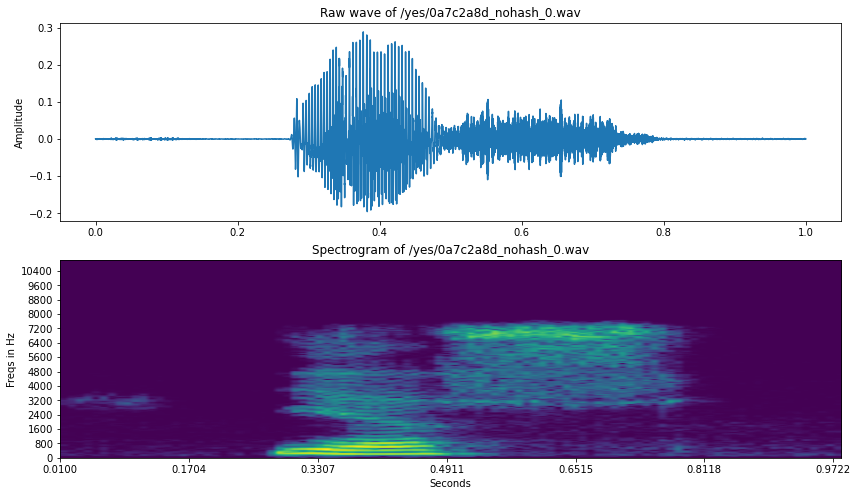

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate / len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [5]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

### MFCC

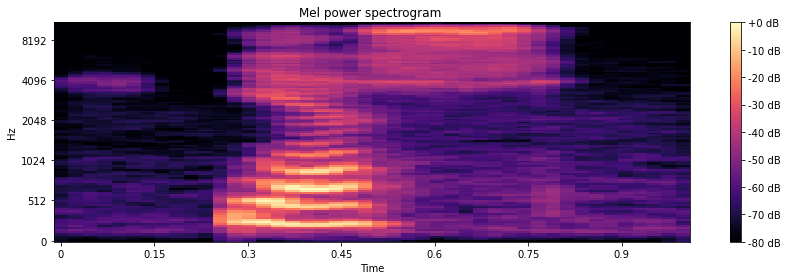

In [6]:
S = librosa.feature.melspectrogram(y= samples, sr=sample_rate, n_mels=128, fmax=8000)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

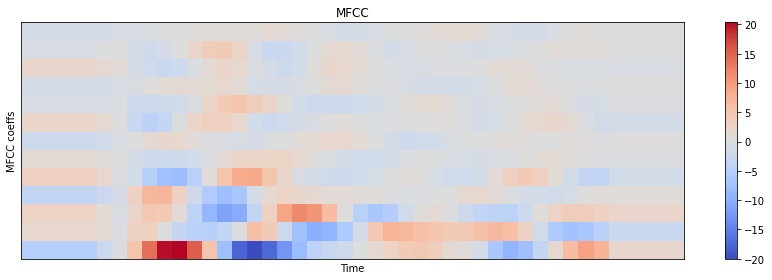

In [7]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

### Spectrogram in 3d

In [8]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "yes" in 3d',
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Silence removal